In [26]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=1
import matplotlib.pyplot as plt
from utils.utils import get_path,lap_eig_decay, diffusion_decay, eff_res_decay, eff_res_corr_decay, dpt_decay
from utils.toydata_utils import get_toy_data
from utils.fig_utils import dist_to_color, dist_to_print, full_dist_to_color
from utils.dist_utils import compute_laplacian, get_sknn
import os
import matplotlib
import numpy as np
import scipy.sparse.linalg

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: CUDA_VISIBLE_DEVICES=1


In [27]:
style_file = "utils.style"
plt.style.use(style_file)
root_path = get_path("data")
fig_path = os.path.join(root_path, "figures")

# Eigenvector decay fig

In [41]:
dist_to_color["dpt"] = '#dd4231'  # add DPT color from below here as well

In [42]:
# get data
seed = 0
sigmas = [0.0, 0.1, 0.25]
n = 1000
d = 50
dataset = "toy_circle"

data = np.array([get_toy_data(dataset = dataset, n= n, d=d, seed=seed, **{"gaussian":{"sigma": sigma}}) for sigma in sigmas])

In [43]:
# get eigenvalues and eigenvectors
k = 15
n_evecs = 999
norms = ["sym"]  # only use symmetric normalization for the plot

evals = {}
evecs = {}
for norm in norms:
    evals_norm = {}
    evecs_norm = {}
    for i, data_sig in enumerate(data):
        sknn_coo = get_sknn(data_sig, k=k)

        L = compute_laplacian(sknn_coo, normalization=norm)

        # compute eigenvectors, following the setting in the UMAP code base
        eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(
                        L,
                        n_evecs,
                        which="SM",
                        tol=1e-4,
                        v0=np.ones(L.shape[0]),
                        maxiter=L.shape[0] * 5,
                    )
        evals_norm[sigmas[i]] = eigenvalues
        evecs_norm[sigmas[i]] = eigenvectors
        print(f"Done with norm {norm} and sigma {sigmas[i]}")
    evals[norm] = evals_norm
    evecs[norm] = evecs_norm

Done with norm sym and sigma 0.0
Done with norm sym and sigma 0.1
Done with norm sym and sigma 0.25


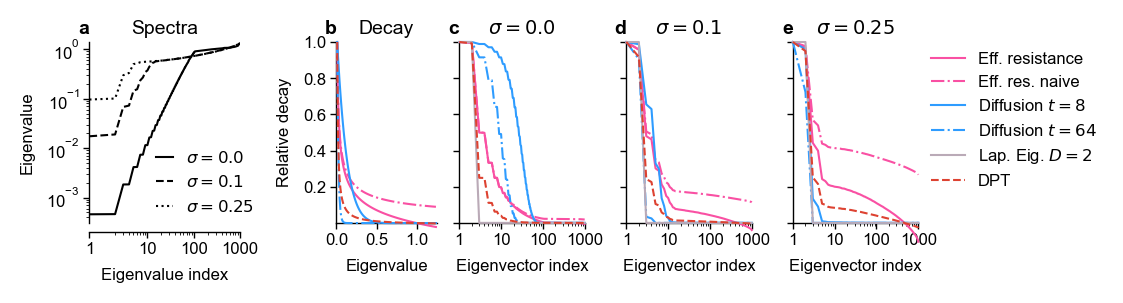

In [52]:
# plot figure
fig, ax = plt.subplots(ncols=5, width_ratios=(1.2, 0.8,1,1,1), figsize=(5.5, 1.4))


letters = "abcde"

# panel a with eigenvalues for different noise levels
linestyles = ["solid", "dashed", "dotted"]
for j, sigma in enumerate(sigmas):
    ax[0].plot(np.arange(1, 999), evals["sym"][sigma][1:], label=f"$\sigma = {sigma}$", c="k", linestyle=linestyles[j])
ax[0].legend(frameon=False, loc=(0.4, 0.01), handlelength=1.0)
ax[0].set_xscale("symlog")
ax[0].set_yscale("log")
ax[0].set_xlim(1, 1000)
ax[0].set_ylim(None, 1.4)
ax[0].spines['left'].set_position(('data', 1))
ax[0].spines['bottom'].set_position(('data', 0.0002))

ax[0].set_xticks([1, 10, 100, 1000])
ax[0].set_xticklabels([1, 10, 100, 1000])

ax[0].xaxis.set_minor_locator(matplotlib.ticker.LogLocator(base=10.0, subs=(0.1, 0.2, 0.3, 0.4, 0.5,  0.6, 0.7, 0.8, 0.9)))
ax[0].set_title("Spectra")
ax[0].set_title(
    letters[0],
    ha="right",
    loc="left",
    fontweight="bold",
)
ax[0].set_ylabel("Eigenvalue")
ax[0].set_xlabel("Eigenvalue index")


cmap = plt.get_cmap('tab20')

# panel b with the eigenvector decay functions
n_xvals = 100
possible_evals = np.arange(1, 1.25* n_xvals) / n_xvals
ax[1].plot(possible_evals, eff_res_corr_decay(possible_evals), label="Eff. resistance", c=dist_to_color["eff_res"], zorder=10, clip_on=False)
ax[1].plot(possible_evals, eff_res_decay(possible_evals), label="Eff. res. naive", c=dist_to_color["eff_res"], linestyle="dashdot", zorder=10, clip_on=False)
ax[1].plot(possible_evals, diffusion_decay(possible_evals, t=8), label="Diffusion $t = 8$", c=dist_to_color["diffusion"], zorder=10, clip_on=False)
ax[1].plot(possible_evals, diffusion_decay(possible_evals, t=64), label="Diffusion $t = 64$", c=dist_to_color["diffusion"], linestyle="dashdot", zorder=10, clip_on=False)
ax[1].plot(possible_evals, dpt_decay(possible_evals), label="DPT", c=dist_to_color["dpt"], linestyle="dashed", zorder=10, clip_on=False)

ax[1].set_xticks([0, 0.5, 1.0])
ax[1].set_ylim(0.001, 1)
ax[1].set_xlim(0, 1.25)

ax[1].spines['left'].set_position(('data', 0))
ax[1].spines['bottom'].set_position(('data', 0))

ax[1].set_xlabel("Eigenvalue")
ax[1].set_ylabel("Relative decay")
ax[1].set_title("Decay")
ax[1].set_title(
    letters[1],
    ha="right",
    loc="left",
    fontweight="bold",
)

# remaining panels with the decay of each eigenvector, one for each noise level
for i, sigma in enumerate([0.0, 0.1, 0.25]):
    i = i+2
    ax[i].plot(np.arange(1, 999), eff_res_corr_decay(evals["sym"][sigma][1:]), label="Eff. resistance", c=dist_to_color["eff_res"], clip_on=False, zorder =5)
    ax[i].plot(np.arange(1, 999), eff_res_decay(evals["sym"][sigma][1:]), label="Eff. res. naive", c=dist_to_color["eff_res"], clip_on=False, linestyle="dashdot", zorder =5)
    ax[i].plot(np.arange(1, 999), diffusion_decay(evals["sym"][sigma][1:], t=8), label="Diffusion $t = 8$", c=dist_to_color["diffusion"], clip_on=False, zorder =5)
    ax[i].plot(np.arange(1, 999), diffusion_decay(evals["sym"][sigma][1:], t=64), label="Diffusion $t = 64$", c=dist_to_color["diffusion"], clip_on=False, linestyle="dashdot", zorder =5)
    ax[i].plot(np.arange(1, 999), lap_eig_decay(evals["sym"][sigma][1:], n_evecs=2), label="Lap. Eig. $D=2$", c=dist_to_color["spectral"], clip_on=False, zorder =5)
    ax[i].plot(np.arange(1, 999), dpt_decay(evals["sym"][sigma][1:]), label="DPT", c=dist_to_color["dpt"], linestyle="dashed", clip_on=False, zorder =5)
    
    ax[i].set_xscale("log")
    ax[i].set_xscale("log")
    ax[i].set_ylim(0, 1)
    ax[i].set_xlim(1, 1000)
    
    ax[i].spines['left'].set_position(('data', 1))
    ax[i].spines['bottom'].set_position(('data', 0))

    if i != 0:
        ax[i].set_yticklabels([])
    ax[i].set_xlabel("Eigenvector index")
    ax[i].set_xticks([1, 10, 100, 1000])    
    ax[i].set_xticklabels([1, 10, 100, 1000], zorder=6)   
    if i == 4:
        ax[i].legend(frameon=False, loc=(1.05,0.15))
    ax[i].set_title(f"$\sigma = {sigma}$")
    ax[i].set_title(
    letters[i],
    ha="right",
    loc="left",
    fontweight="bold",
)
fig.savefig(os.path.join(fig_path, "fig_eig_decay_log.pdf"))

# Check stability of effective resistance

In [20]:
from utils.dist_utils import get_dist
from utils.io_utils import load_multiple_res

In [49]:
# get data
seed = 2
sigmas = [0.0, 0.25]
n = 1000
d = 50
dataset = "toy_circle"
distances = {"euclidean": {},
             "eff_res": {"corrected": True, "weighted": False, "k": 100, "disconnect": True}}
data = {sigma: get_toy_data(dataset = dataset, n= n, d=d, seed=seed, **{"gaussian":{"sigma": sigma}}) for sigma in sigmas}

In [50]:
dists = {distance: {sigma: get_dist(data[sigma], distance, **distances[distance]) for sigma in sigmas} for distance in distances}

In [27]:
all_res = load_multiple_res(datasets="toy_circle", distances=distances, root_path=root_path, n=n, embd_dims=d, sigmas=sigmas, seeds=[0], n_threads=10)

In [51]:
max_displacement = np.sqrt(((data[0.0] - data[0.25])**2).sum(-1)).max()
print(max_displacement)

In [52]:
for sigma in sigmas:
    print(dists["euclidean"][sigma].max())

In [42]:
for sigma in sigmas:
    print(dists["eff_res"][sigma].mean())

In [41]:
for distance in distances:
    for sigma in sigmas:
        full_dist = list(all_res[distance].keys())[0]
        dgms = all_res[distance][full_dist][sigma]["dgms"][1]
        print(f"Distance {distance} sigma {sigma} max death {dgms[:,1].max()} min birth {dgms[:, 0].min()}")

# Eigenvectors of the blob

In [23]:
from utils.toydata_utils import get_toy_data
import scipy.sparse.linalg
from utils.dist_utils import  get_sknn, compute_laplacian
from utils.utils import get_path,lap_eig_decay, diffusion_decay, eff_res_decay, eff_res_corr_decay


In [24]:
k = 100
data = get_toy_data(dataset="toy_blob", n=1000, d=50, seed=0, **{"gaussian":{"sigma": 0.0125}})

In [25]:
sknn_coo = get_sknn(data, k=k)

L = compute_laplacian(sknn_coo, normalization="sym")
n_evecs = 999
# compute eigenvectors, following the setting in the UMAP code base
eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(
                L,
                n_evecs,
                which="SM",
                tol=1e-4,
                v0=np.ones(L.shape[0]),
                maxiter=L.shape[0] * 5,
            )


In [68]:
fig, ax = plt.subplots(figsize=(5.5, 2))
ax.plot(eigenvalues[1:])
ax.set_yscale("log")
ax.axvline(50, c="k", linestyle="dashed")

In [72]:
eff_res = eff_res_corr_decay(eigenvalues[1:])
diffusion = diffusion_decay(eigenvalues[1:], t=8)

In [74]:
fig, ax = plt.subplots(ncols=2, figsize=(5.5, 2))
ax[0].plot(eff_res / eff_res.max())
ax[0].axvline(50, c="k", linestyle="dashed")
ax[1].plot(diffusion / diffusion.max())
ax[1].axvline(50, c="k", linestyle="dashed")

# Comparison of spectral methods

In [6]:
from utils.io_utils import load_multiple_res
from utils.pd_utils import filter_dgms, compute_outlier_scores
from utils.fig_utils import dataset_to_print, full_dist_to_print
import glasbey

In [7]:
datasets = ["toy_circle", "inter_circles", "eyeglasses"] #, "torus", "toy_sphere"]

embd_dim = 50
sigmas = np.linspace(0.0, 0.35, 29)
sigmas = np.array([np.format_float_positional(sigma, precision=4, unique=True, trim='0') for sigma in sigmas]).astype(float)
seeds = [0, 1, 2]
n = 1000

# different datas
sigmas_per_dataset = {}
for dataset in datasets:
    if dataset == "eyeglasses":
        sigmas_per_dataset[dataset] = sigmas[:13]
    else:
        sigmas_per_dataset[dataset] = sigmas

## Find best hyperparameters

In [8]:
# The best hyperparameters are hard-coded below and do not have to be reselected, unless the set of methods and possible hyperparameters is changed.

In [9]:
distances = {
    "euclidean": [{}],    
    "potential": [
        {"k": 15, "t": 8, "kernel": "sknn", "include_self": False},
        {"k": 100, "t": 8, "kernel": "sknn", "include_self": False},
        {"k": 15, "t": 64, "kernel": "sknn", "include_self": False},
        {"k": 100, "t": 64, "kernel": "sknn", "include_self": False},
    ],
    "dpt": [
        {"k": 15, "normalization": "sym", "weighted": False},
        {"k": 100, "normalization": "sym", "weighted": False},
        {"k": 15, "normalization": "symd", "weighted": False},
        {"k": 100, "normalization": "symd", "weighted": False},
        {"k": 15, "normalization": "rw", "weighted": False},
        {"k": 100, "normalization": "rw", "weighted": False}
    ],
    "eff_res": [
        {"corrected": True, "weighted": False, "k": 15, "disconnect": True},
        {"corrected": True, "weighted": False, "k": 100, "disconnect": True,}
    ],
    "diffusion": [
        {"k": 15, "t": 8, "kernel": "sknn", "include_self": False},
        {"k": 100, "t": 8, "kernel": "sknn", "include_self": False},
        {"k": 15, "t": 64, "kernel": "sknn", "include_self": False},
        {"k": 100, "t": 64, "kernel": "sknn", "include_self": False},
    ],
    "spectral": [
        {"k": 15, "normalization": "sym", "n_evecs": 2, "weighted": False},
        {"k": 15, "normalization": "sym", "n_evecs": 5, "weighted": False},
        {"k": 15, "normalization": "sym", "n_evecs": 10, "weighted": False},
    ],
}


In [10]:
#load data
all_res = {}
for dataset in datasets:
    all_res[dataset] = load_multiple_res(datasets=dataset,
                                         distances=distances,
                                         root_path=get_path("data"),
                                         n=n,
                                         seeds=seeds,
                                         sigmas=sigmas_per_dataset[dataset],
                                         embd_dims=embd_dim,
                                         n_threads=10)

Done with toy_circle 50 euclidean n_outliers=0, perturbation=None
Done with toy_circle 50 potential_k_15_t_8_kernel_sknn_include_self_False n_outliers=0, perturbation=None
Done with toy_circle 50 potential_k_100_t_8_kernel_sknn_include_self_False n_outliers=0, perturbation=None
Done with toy_circle 50 potential_k_15_t_64_kernel_sknn_include_self_False n_outliers=0, perturbation=None
Done with toy_circle 50 potential_k_100_t_64_kernel_sknn_include_self_False n_outliers=0, perturbation=None
Done with toy_circle 50 dpt_k_15_normalization_sym_weighted_False n_outliers=0, perturbation=None
Done with toy_circle 50 dpt_k_100_normalization_sym_weighted_False n_outliers=0, perturbation=None
Done with toy_circle 50 dpt_k_15_normalization_symd_weighted_False n_outliers=0, perturbation=None
Done with toy_circle 50 dpt_k_100_normalization_symd_weighted_False n_outliers=0, perturbation=None
Done with toy_circle 50 dpt_k_15_normalization_rw_weighted_False n_outliers=0, perturbation=None
Done with toy

In [11]:
# filtering
dob = 1.25
all_res = filter_dgms(dgms=all_res, dob=dob, dim=1, binary=True)
#all_res = filter_dgms(dgms=all_res, dob=dob, dim=2, binary=True)

In [12]:
# compute the detection score
cycles_per_dataset = {
    1: {
        "toy_circle": 1,
        "inter_circles": 2,
        "eyeglasses": 1,
        #"torus": 2,
        #"toy_sphere": 0,  # so that the curves are high for AUC
    },
    #2: {
    #    "toy_sphere": 1,
    #    "torus": 1 
    #}
}

outlier_scores_1d = {dataset: compute_outlier_scores(all_res[dataset], 
                                                     n_features=cycles_per_dataset[1][dataset],
                                                     dim=1)
                     for dataset in cycles_per_dataset[1]}
#outlier_scores_2d = {dataset: compute_outlier_scores(all_res[dataset],
#                                                     n_features=cycles_per_dataset[2][dataset],
#                                                     dim=2)
#                     for dataset in cycles_per_dataset[2]}

outlier_scores = {
    1: outlier_scores_1d,
    #2: outlier_scores_2d
}

In [13]:
# compute area under the curves
aucs = {}

for feature_dim in outlier_scores:
    auc_by_feature_dim = {}
    for dataset in outlier_scores[feature_dim]:
        auc_by_dataset = {}
        for dist in outlier_scores[feature_dim][dataset]:
            auc_per_method = {}
            for full_dist in outlier_scores[feature_dim][dataset][dist]:
                auc_per_method[full_dist] = outlier_scores[feature_dim][dataset][dist][full_dist].mean(1).sum() / len(sigmas_per_dataset[dataset])
            auc_by_dataset[dist] = auc_per_method
        auc_by_feature_dim[dataset] = auc_by_dataset
    aucs[feature_dim] = auc_by_feature_dim

In [14]:
# Each panel selects the best method individually. This means different feature dimensions for torus and sphere can select different hyperparameters.

best_method_per_dataset = {}
for feature_dim in aucs:
    best_method_per_feature_dim = {}

    for dataset in aucs[feature_dim]:
        best_method_this_dataset = {}
        for dist in aucs[feature_dim][dataset]:
            best_full_dist = None
            best_auc = 0
            for full_dist in aucs[feature_dim][dataset][dist]:
                auc = aucs[feature_dim][dataset][dist][full_dist]
                if auc > best_auc:
                    best_auc = auc
                    best_full_dist = full_dist
            best_method_this_dataset[dist] = best_full_dist
        best_method_per_feature_dim[dataset] = best_method_this_dataset
    best_method_per_dataset[feature_dim] = best_method_per_feature_dim

In [15]:
# print best hyperparameter settings 
for feature_dim in best_method_per_dataset:
    print("~"*40)
    print(f"Topological dimension: {feature_dim}")
    for dataset in best_method_per_dataset[feature_dim]:
        for dist in best_method_per_dataset[feature_dim][dataset]:
            print(dataset_to_print[dataset], full_dist_to_print[best_method_per_dataset[feature_dim][dataset][dist]].replace("\n", " "))
        print("\n")


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Topological dimension: 1
Circle Euclidean
Circle Potential $k=100, t=8$
Circle DPT symd $k=100$
Circle Effective resistance $k=100$
Circle Diffusion $k=15, t=8$
Circle Lap. Eig. $k=15, \tilde{d}=2$


Linked circles Euclidean
Linked circles Potential $k=100, t=8$
Linked circles DPT rw $k=15$
Linked circles Effective resistance $k=15$
Linked circles Diffusion $k=15, t=8$
Linked circles Lap. Eig. $k=15, \tilde{d}=5$


Eyeglasses Euclidean
Eyeglasses Potential $k=15, t=64$
Eyeglasses DPT sym $k=15$
Eyeglasses Effective resistance $k=15$
Eyeglasses Diffusion $k=15, t=64$
Eyeglasses Lap. Eig. $k=15, \tilde{d}=2$




In [16]:
best_method_per_dataset_dict = {
    1: {'toy_circle': 
            {'euclidean': [{}], 
             'potential': [{"k": 100, "t": 8, "kernel": "sknn", "include_self": False}],
             'dpt': [{"k": 100, "normalization": "symd", "weighted": False}],
             'eff_res': [{"corrected": True, "weighted": False, "k": 100, "disconnect": True,}], 
             'diffusion': [{"k": 15, "t": 8, "kernel": "sknn", "include_self": False}], 
             'spectral': [{"k": 15, "normalization": "sym", "n_evecs": 2, "weighted": False}]
             },
        'inter_circles': 
            {'euclidean': [{}], 
                'potential': [{"k": 100, "t": 8, "kernel": "sknn", "include_self": False}],
                'dpt': [{"k": 15, "normalization": "rw", "weighted": False}],
             'eff_res': [{"corrected": True, "weighted": False, "k": 15, "disconnect": True,}], 
             'diffusion': [{"k": 15, "t": 8, "kernel": "sknn", "include_self": False}],
                'spectral': [{"k": 15, "normalization": "sym", "n_evecs": 5, "weighted": False}]
             },
        'eyeglasses': 
            {'euclidean': [{}],
             'potential': [{"k": 15, "t": 64, "kernel": "sknn", "include_self": False}],
             'dpt': [{"k": 15, "normalization": "sym", "weighted": False}],
             'eff_res': [{"corrected": True, "weighted": False, "k": 15, "disconnect": True,}],
             'diffusion':  [{"k": 15, "t": 64, "kernel": "sknn", "include_self": False}], 
            'spectral': [{"k": 15, "normalization": "sym", "n_evecs": 2, "weighted": False}]
             }
        }
}

In [17]:
selected_res = {}
for feature_dim in best_method_per_dataset_dict:
    sel_res_dim = {}
    for dataset in best_method_per_dataset_dict[feature_dim]:
        sel_res_dim[dataset] = load_multiple_res(datasets=dataset, 
                                                  distances=best_method_per_dataset_dict[feature_dim][dataset],
                                                  root_path=root_path,
                                                  n=n,
                                                  seeds=seeds,
                                                  sigmas=sigmas_per_dataset[dataset],
                                                  embd_dims=embd_dim, 
                                                  n_threads=10)
    selected_res[feature_dim] = sel_res_dim

Done with toy_circle 50 euclidean n_outliers=0, perturbation=None
Done with toy_circle 50 potential_k_100_t_8_kernel_sknn_include_self_False n_outliers=0, perturbation=None
Done with toy_circle 50 dpt_k_100_normalization_symd_weighted_False n_outliers=0, perturbation=None
Done with toy_circle 50 eff_res_corrected_True_weighted_False_k_100_disconnect_True n_outliers=0, perturbation=None
Done with toy_circle 50 diffusion_k_15_t_8_kernel_sknn_include_self_False n_outliers=0, perturbation=None
Done with toy_circle 50 spectral_k_15_normalization_sym_n_evecs_2_weighted_False n_outliers=0, perturbation=None
Done with inter_circles 50 euclidean n_outliers=0, perturbation=None
Done with inter_circles 50 potential_k_100_t_8_kernel_sknn_include_self_False n_outliers=0, perturbation=None
Done with inter_circles 50 dpt_k_15_normalization_rw_weighted_False n_outliers=0, perturbation=None
Done with inter_circles 50 eff_res_corrected_True_weighted_False_k_15_disconnect_True n_outliers=0, perturbation=

In [18]:
# filtering
dob = 1.25
for feature_dim in selected_res:
    selected_res[feature_dim] = filter_dgms(dgms=selected_res[feature_dim], dob=dob, binary=True, dim=feature_dim)
# compute the detection scores for each method
cycles_per_dataset = {
    1: {
        "toy_circle": 1,
        "inter_circles": 2,
        "eyeglasses": 1,
        #"toy_sphere": 1,  # so that the curves are low
        #"torus": 2,
        #"toy_blob": 1, # so that the curves are low
    },
    #2: {
    #    "toy_sphere": 1,
    #    "torus": 1
    #}
}
selected_outlier_scores_1d = {dataset: compute_outlier_scores(selected_res[1][dataset],
                                                              n_features=cycles_per_dataset[1][dataset],
                                                              dim=1)
                              for dataset in cycles_per_dataset[1]}
#selected_outlier_scores_2d = {dataset: compute_outlier_scores(selected_res[2][dataset],
#                                                              n_features=cycles_per_dataset[2][dataset],
#                                                              dim=2)
#                              for dataset in cycles_per_dataset[2]}

selected_outlier_scores = {
    1: selected_outlier_scores_1d,
    #2: selected_outlier_scores_2d,
}

In [29]:
block_lengths = [len(distances[dist]) for dist in distances]
del block_lengths[0]  # remove euclidean
colors = glasbey.create_block_palette(block_lengths)
colors.insert(0, "k")  # add black for euclidean

my_full_dist_to_color = {full_dist: color for full_dist, color in zip([full_dists for dist in ["euclidean", "potential", "dpt"] for full_dists in all_res["toy_circle"][dist]], colors)}

for dist in ["eff_res", "diffusion", "spectral"]:
    for full_dist in all_res["toy_circle"][dist]:
        my_full_dist_to_color[full_dist] = full_dist_to_color[full_dist]


my_dist_to_color = dist_to_color.copy()
for dist_ind, dist in enumerate(["euclidean", "potential", "dpt"]):
    if dist == "euclidean":
        my_dist_to_color[dist] = "k"
        continue
    block_start = 1 + sum(block_lengths[:dist_ind-1])
    block_end = block_start + block_lengths[dist_ind-1]
    mid_ind = np.ceil((block_start + block_end) / 2).astype(int)
    my_dist_to_color[dist] = colors[mid_ind]

In [30]:
print(dist_to_color)

{'euclidean': 'k', 'umap': '#7dd3db', 'fermat': '#249636', 'dtm': '#dc1e11', 'eff_res': '#f950a3', 'core': '#b2a358', 'sknn_dist': '#c9abf9', 'tsne': '#95a1a3', 'diffusion': '#2e9cff', 'spectral': '#baaab7', 'umap_embd': '#a89e8a', 'tsne_embd': '#ff7ae2'}


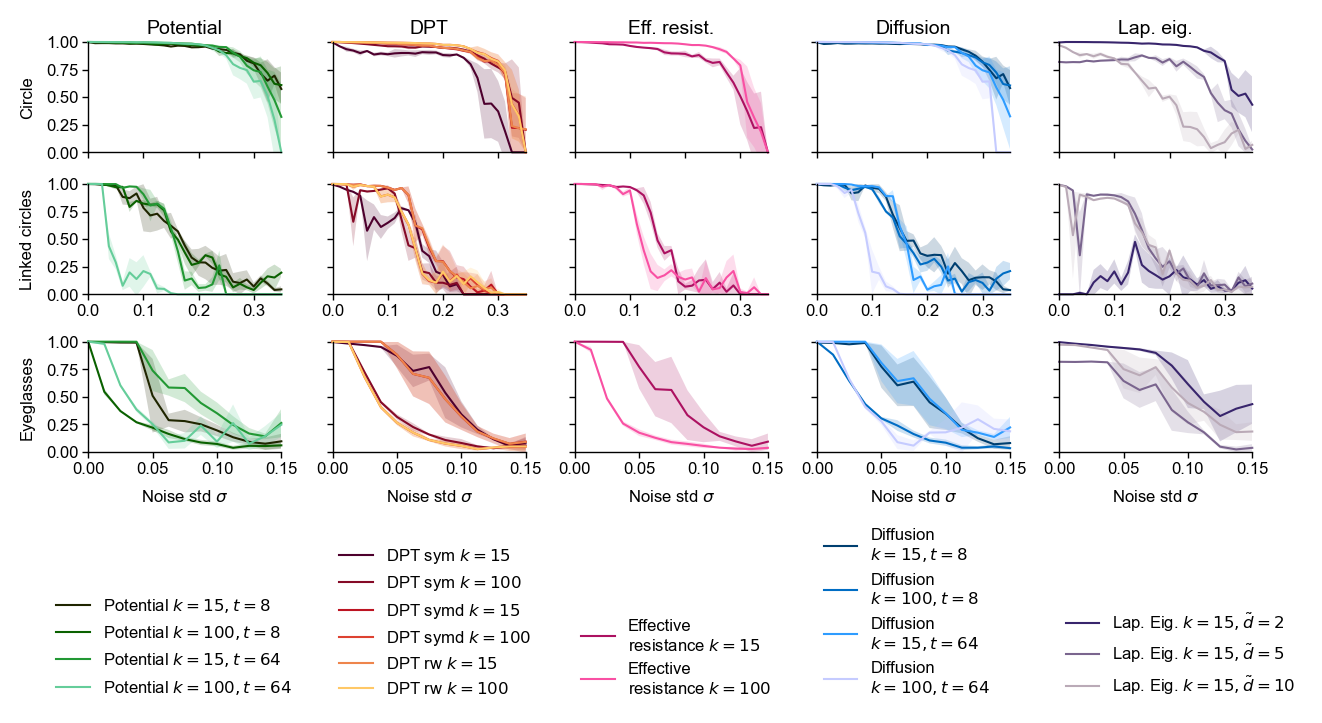

In [31]:
# plot all results
ncols = 5
nrows = 3

letters = "abcdefghijklmnopqrst"
mosaic = "abcde\nfghij\nklmno\npqrst"
fig, ax_dict = plt.subplot_mosaic(mosaic=mosaic, figsize=(6.5, 3.5))

ax = []
for j in range(nrows+1):
    ax.append([ax_dict[letters[j*ncols + i]] for i in range(ncols)])

ax = np.array(ax)

for j, dataset in enumerate(selected_outlier_scores[1]):
    ax[j, 0].set_ylabel(dataset_to_print[dataset])
    
    for i in range(ncols):
        method_id = i+1
        dist = list(selected_res[1][dataset].keys())[method_id]
        
        for submethod_counter, full_dist in enumerate(outlier_scores[1][dataset][dist]):
            scores =  outlier_scores[1][dataset][dist][full_dist]
            mean = scores.mean(1)
            std = scores.std(1)
            ax[j, i].plot(sigmas_per_dataset[dataset], 
                       mean,
                       label=full_dist_to_print[full_dist],
                       c=my_full_dist_to_color[full_dist],
                       clip_on=False,)
            ax[j, i].fill_between(sigmas_per_dataset[dataset],
                               mean-std,
                               mean+std,
                               alpha=0.2,
                               color=my_full_dist_to_color[full_dist],
                               edgecolor="none",               
            )
            if j == 0:
                ax[j, i].set_title(f"{dist_to_print[dist]}")
            
            ax[j, i].set_ylim(0, 1)
            ax[j, i].set_xlim(0, sigmas_per_dataset[dataset].max())
            
        if j==2:  
            ax[j, i].set_xlabel("Noise std $\sigma$")
            #ax[j, i].legend(loc=(0.0, -1.9), frameon=False)
        elif j == 0 or j == 1:
            ax[j, i].set_xticks([0.0, 0.1, 0.2, 0.3])
            if j ==0:
                ax[j, i].set_xticklabels([])

        ax[j, i].set_yticks([0.0, 0.25, 0.5, 0.75, 1.0])
        if i != 0:
            ax[j, i].set_yticklabels([])
            


for i in range(ncols):
    handles, labels = ax[0, i].get_legend_handles_labels()
    if i == 0:
        legend = ax[-1, i].legend(loc=(-0.2, 0),
                                  ncols=1,
                                  handles=handles,
                                  frameon=False
                                  )
    else:
        legend = ax[-1, i].legend(loc=(0.0, 0),
                                  ncols=1,
                                  handles=handles,
                                  frameon=False
                                  )

    ax[-1, i].axis("off")
    
fig.savefig(os.path.join(fig_path, f"fig_comparison_spectrals.pdf"), dpi=300)

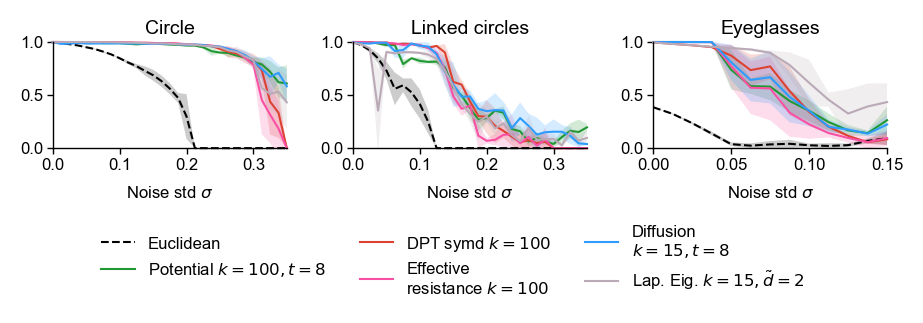

In [33]:
mosaic = "abc\nddd"
fig, ax_dict = plt.subplot_mosaic(mosaic=mosaic, height_ratios=(1, 0.1), figsize=(4.5, 1.5))
ax = list(ax_dict.values())
for i, dataset in enumerate(selected_outlier_scores[1]):
    for dist in selected_outlier_scores[1][dataset]:
        best_full_dist = list(selected_outlier_scores[1][dataset][dist].keys())[0]
        best_scores =  selected_outlier_scores[1][dataset][dist][best_full_dist]
        best_mean = best_scores.mean(1)
        best_std = best_scores.std(1)
        
        linestyle="solid" if dist != "euclidean" else "dashed"
        ax[i].plot(sigmas_per_dataset[dataset], 
                    best_mean, 
                    label=full_dist_to_print[best_full_dist],
                    c=my_dist_to_color[dist],
                    clip_on=False,
                   linestyle=linestyle)
        ax[i].fill_between(sigmas_per_dataset[dataset],
                               best_mean-best_std,
                               best_mean+best_std,
                               alpha=0.2,
                               color=my_dist_to_color[dist],
                               edgecolor="none",               
            )
        ax[i].set_ylim(0, 1)
        ax[i].set_xlim(0, sigmas_per_dataset[dataset].max())
        ax[i].set_xlabel("Noise std $\sigma$")
        ax[i].set_title(dataset_to_print[dataset])
        
handles, labels = ax[0].get_legend_handles_labels()
legend = ax[-1].legend(loc=(0.05, 0.0),
                       ncols=3,
                       handles=handles,
                       frameon=False
      )        
ax[-1].axis("off")

fig.savefig(os.path.join(fig_path, "fig_comparison_best_spectrals.pdf"), dpi=300)